In [27]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Dati nostri

In [28]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
#print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

In [29]:
expanded_train_dna_features = torch.load('dna_train_features.pt')
expanded_train_dna_labels = torch.load('dna_train_labels.pt')
image_train_features = torch.load('img_train_features.pt')
image_train_labels= torch.load('img_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [30]:
expanded_val_dna_features = torch.load('dna_val_features.pt')
expanded_val_dna_labels = torch.load('dna_val_labels.pt')
image_val_features = torch.load('img_val_features.pt')
image_val_labels = torch.load('img_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [31]:
expanded_test_dna_features = torch.load('dna_test_features.pt')
expanded_test_dna_labels = torch.load('dna_test_labels.pt')
image_test_features = torch.load('img_test_features.pt')
image_test_labels = torch.load('img_test_labels.pt')
assert((image_test_labels == expanded_test_dna_labels).all())
n_classes = 1050

In [124]:
'''class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        #self.drop1 = nn.Dropout(p=0.7)
        self.linear1 = nn.Linear(3250,3000)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(3000,2000)
        self.act2 = nn.LeakyReLU()
        self.linearHeadGenus = nn.Linear(2000,372)
        self.linearHeadSpecies = nn.Linear(2000,n_classes)
    def forward(self, x):
        #x = self.drop1(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x_species = self.linearHeadSpecies(x)
        x_genus = self.linearHeadGenus(x)
        x_species = torch.nn.functional.softmax(x_species)
        x_genus = torch.nn.functional.softmax(x_genus)
        return x_species,x_genus
'''
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout = nn.Dropout(p=0.8)
        self.linear1 = nn.Linear(5298,372)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(372,n_classes)
        self.act2 = nn.Softmax()
    def forward(self, x):
        x = self.dout(x)
        x = self.linear1(x)
        x_genus = torch.nn.functional.softmax(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x,x_genus

'''class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout0 = nn.Dropout()
        self.linear1 = nn.Linear(5298,5000)
        self.act1 = nn.LeakyReLU()
        self.dout1 = nn.Dropout()

        self.linearG = nn.Linear(5000,372)
        self.linearS = nn.Linear(5000,n_classes)
    def forward(self, x):
        x = self.dout0(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dout1(x)
        x_species = self.linearS(x)
        x_genus = self.linearG(x)

        x_species = nn.functional.softmax(x_species)
        x_genus = nn.functional.softmax(x_genus)
        return x_species,x_genus

#species2genus = np.array(species2genus)'''

'class InsectNet(torch.nn.Module):\n    def __init__(self):\n        super(InsectNet, self).__init__()\n        self.dout0 = nn.Dropout()\n        self.linear1 = nn.Linear(5298,5000)\n        self.act1 = nn.LeakyReLU()\n        self.dout1 = nn.Dropout()\n\n        self.linearG = nn.Linear(5000,372)\n        self.linearS = nn.Linear(5000,n_classes)\n    def forward(self, x):\n        x = self.dout0(x)\n        x = self.linear1(x)\n        x = self.act1(x)\n        x = self.dout1(x)\n        x_species = self.linearS(x)\n        x_genus = self.linearG(x)\n\n        x_species = nn.functional.softmax(x_species)\n        x_genus = nn.functional.softmax(x_genus)\n        return x_species,x_genus\n\n#species2genus = np.array(species2genus)'

In [125]:
sorted_keys = sorted(species2genus.keys())
species2genus = np.array([species2genus[key] for key in sorted_keys])
print(species2genus)
species2genus = species2genus[...,np.newaxis]
species2genus.shape

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [126]:
species2genus


array([[234],
       [234],
       [235],
       ...,
       [ 44],
       [ 44],
       [311]])

In [127]:
image_train_features.shape

torch.Size([13039, 2048])

In [128]:
image_train_labels.shape

torch.Size([13039])

In [129]:
expanded_train_dna_features.shape

torch.Size([13039, 3250])

In [130]:
expanded_train_dna_labels.shape


torch.Size([13039])

# CONTROLLARE STA ROBA DI TRAIN VAL PRIMA DELLO SCALER

In [131]:
is_train_val = False 
print("ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels

scaler = StandardScaler()

complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [132]:
complete_train_features_scaled.shape

(13039, 5298)

In [133]:
complete_val_features_scaled.shape

(6955, 5298)

In [134]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [135]:
species2genus.min()
species2genus.max()

371

In [136]:
species2genus.shape

(1050, 1)

In [137]:
(1040, 1, 1)

(1040, 1, 1)

In [138]:
complete_train_features_scaled.shape

torch.Size([13039, 5298])

In [139]:
d_train[0][0].shape

torch.Size([5298])

## Classification

# Fitting model

In [140]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [141]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=2*len(train_loader))

In [142]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        for features,labels in tqdm(dataloaders['train']):
            
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()

            #print(genus_labels.shape)
            #print(labels.shape)
            #break
            predicted_labels,predicted_genus_labels = model(features)
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            #print(train_genus_loss.shape)
            #print(train_loss.shape)
            
            train_loss+=train_genus_loss
            
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            _, preds = torch.max(predicted_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
        train_losses.append(train_loss)
        running_val_corrects = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc))
    return train_losses

In [160]:

_ = fit(100,dataloaders,optimizer,model)

  0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipykernel_3949/509102700.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/100], train_loss: -1.9992,  train_score: 0.9626,val_loss: -0.4379,  val_score: 0.4393


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/100], train_loss: -1.9724,  train_score: 0.9623,val_loss: -0.4407,  val_score: 0.4395


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/100], train_loss: -1.9736,  train_score: 0.9631,val_loss: -0.4229,  val_score: 0.4400


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/100], train_loss: -1.9258,  train_score: 0.9640,val_loss: -0.4322,  val_score: 0.4410


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/100], train_loss: -1.9483,  train_score: 0.9643,val_loss: -0.4249,  val_score: 0.4411


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/100], train_loss: -1.8968,  train_score: 0.9660,val_loss: -0.4452,  val_score: 0.4423


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/100], train_loss: -1.9150,  train_score: 0.9659,val_loss: -0.4425,  val_score: 0.4423


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/100], train_loss: -1.9485,  train_score: 0.9648,val_loss: -0.4398,  val_score: 0.4418


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/100], train_loss: -1.8712,  train_score: 0.9659,val_loss: -0.4133,  val_score: 0.4421


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/100], train_loss: -1.9998,  train_score: 0.9668,val_loss: -0.4331,  val_score: 0.4421


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/100], train_loss: -1.9998,  train_score: 0.9663,val_loss: -0.4291,  val_score: 0.4421


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/100], train_loss: -1.9737,  train_score: 0.9667,val_loss: -0.4558,  val_score: 0.4424


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/100], train_loss: -1.9485,  train_score: 0.9679,val_loss: -0.4302,  val_score: 0.4431


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/100], train_loss: -1.8937,  train_score: 0.9689,val_loss: -0.4367,  val_score: 0.4434


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/100], train_loss: -1.9951,  train_score: 0.9689,val_loss: -0.4534,  val_score: 0.4436


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/100], train_loss: -1.9482,  train_score: 0.9689,val_loss: -0.4377,  val_score: 0.4428


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/100], train_loss: -1.9483,  train_score: 0.9685,val_loss: -0.4485,  val_score: 0.4427


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/100], train_loss: -1.9419,  train_score: 0.9686,val_loss: -0.4516,  val_score: 0.4427


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/100], train_loss: -1.9388,  train_score: 0.9689,val_loss: -0.4293,  val_score: 0.4430


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/100], train_loss: -1.9742,  train_score: 0.9693,val_loss: -0.4871,  val_score: 0.4428


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21/100], train_loss: -1.9228,  train_score: 0.9696,val_loss: -0.4401,  val_score: 0.4440


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22/100], train_loss: -1.8965,  train_score: 0.9702,val_loss: -0.4573,  val_score: 0.4439


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23/100], train_loss: -1.9482,  train_score: 0.9702,val_loss: -0.4801,  val_score: 0.4437


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24/100], train_loss: -1.9485,  train_score: 0.9705,val_loss: -0.4518,  val_score: 0.4439


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25/100], train_loss: -1.9479,  train_score: 0.9708,val_loss: -0.4505,  val_score: 0.4444


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26/100], train_loss: -1.8315,  train_score: 0.9711,val_loss: -0.4354,  val_score: 0.4450


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27/100], train_loss: -1.9740,  train_score: 0.9722,val_loss: -0.4348,  val_score: 0.4441


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28/100], train_loss: -1.9190,  train_score: 0.9719,val_loss: -0.4388,  val_score: 0.4460


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29/100], train_loss: -1.9486,  train_score: 0.9725,val_loss: -0.4471,  val_score: 0.4454


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30/100], train_loss: -1.9485,  train_score: 0.9743,val_loss: -0.4396,  val_score: 0.4459


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [31/100], train_loss: -1.9210,  train_score: 0.9745,val_loss: -0.4222,  val_score: 0.4466


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [32/100], train_loss: -1.9996,  train_score: 0.9745,val_loss: -0.4438,  val_score: 0.4466


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [33/100], train_loss: -1.9738,  train_score: 0.9750,val_loss: -0.4337,  val_score: 0.4469


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [34/100], train_loss: -1.9738,  train_score: 0.9762,val_loss: -0.4383,  val_score: 0.4469


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [35/100], train_loss: -1.9908,  train_score: 0.9755,val_loss: -0.4331,  val_score: 0.4470


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [36/100], train_loss: -1.9437,  train_score: 0.9758,val_loss: -0.4208,  val_score: 0.4469


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [37/100], train_loss: -1.9199,  train_score: 0.9738,val_loss: -0.4383,  val_score: 0.4469


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [38/100], train_loss: -1.9652,  train_score: 0.9761,val_loss: -0.4519,  val_score: 0.4476


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [39/100], train_loss: -1.9484,  train_score: 0.9766,val_loss: -0.4628,  val_score: 0.4476


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [40/100], train_loss: -1.9475,  train_score: 0.9765,val_loss: -0.4680,  val_score: 0.4477


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [41/100], train_loss: -1.9977,  train_score: 0.9765,val_loss: -0.4690,  val_score: 0.4472


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [42/100], train_loss: -1.9458,  train_score: 0.9768,val_loss: -0.4684,  val_score: 0.4474


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [43/100], train_loss: -1.9431,  train_score: 0.9771,val_loss: -0.4402,  val_score: 0.4477


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [44/100], train_loss: -1.9998,  train_score: 0.9773,val_loss: -0.4654,  val_score: 0.4476


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [45/100], train_loss: -1.9997,  train_score: 0.9772,val_loss: -0.4238,  val_score: 0.4479


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [46/100], train_loss: -1.9995,  train_score: 0.9772,val_loss: -0.4208,  val_score: 0.4479


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [47/100], train_loss: -1.8716,  train_score: 0.9773,val_loss: -0.4827,  val_score: 0.4477


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [48/100], train_loss: -1.9999,  train_score: 0.9773,val_loss: -0.4677,  val_score: 0.4482


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [49/100], train_loss: -1.9997,  train_score: 0.9774,val_loss: -0.4596,  val_score: 0.4483


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [50/100], train_loss: -1.9994,  train_score: 0.9778,val_loss: -0.4378,  val_score: 0.4483


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [51/100], train_loss: -1.9987,  train_score: 0.9780,val_loss: -0.4604,  val_score: 0.4483


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [52/100], train_loss: -1.9487,  train_score: 0.9783,val_loss: -0.4513,  val_score: 0.4487


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [53/100], train_loss: -1.9735,  train_score: 0.9784,val_loss: -0.4671,  val_score: 0.4485


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [54/100], train_loss: -1.9479,  train_score: 0.9785,val_loss: -0.4541,  val_score: 0.4486


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [55/100], train_loss: -1.9481,  train_score: 0.9784,val_loss: -0.4763,  val_score: 0.4486


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [56/100], train_loss: -1.9460,  train_score: 0.9787,val_loss: -0.4456,  val_score: 0.4489


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [57/100], train_loss: -1.9229,  train_score: 0.9784,val_loss: -0.4690,  val_score: 0.4487


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [58/100], train_loss: -1.9230,  train_score: 0.9789,val_loss: -0.4565,  val_score: 0.4487


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [59/100], train_loss: -1.9449,  train_score: 0.9781,val_loss: -0.4584,  val_score: 0.4489


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [60/100], train_loss: -1.9230,  train_score: 0.9789,val_loss: -0.4422,  val_score: 0.4487


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [61/100], train_loss: -1.9485,  train_score: 0.9784,val_loss: -0.4532,  val_score: 0.4485


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [62/100], train_loss: -1.8717,  train_score: 0.9786,val_loss: -0.4402,  val_score: 0.4485


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [63/100], train_loss: -1.9833,  train_score: 0.9782,val_loss: -0.4754,  val_score: 0.4487


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [64/100], train_loss: -1.9741,  train_score: 0.9790,val_loss: -0.4417,  val_score: 0.4485


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [65/100], train_loss: -1.9985,  train_score: 0.9791,val_loss: -0.4701,  val_score: 0.4492


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [66/100], train_loss: -1.9486,  train_score: 0.9793,val_loss: -0.4496,  val_score: 0.4492


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [67/100], train_loss: -1.9997,  train_score: 0.9795,val_loss: -0.4345,  val_score: 0.4492


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [68/100], train_loss: -1.9484,  train_score: 0.9797,val_loss: -0.4660,  val_score: 0.4490


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [69/100], train_loss: -1.9743,  train_score: 0.9792,val_loss: -0.4609,  val_score: 0.4490


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [70/100], train_loss: -1.9741,  train_score: 0.9798,val_loss: -0.4605,  val_score: 0.4492


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [71/100], train_loss: -1.9486,  train_score: 0.9792,val_loss: -0.4847,  val_score: 0.4490


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [72/100], train_loss: -1.9741,  train_score: 0.9804,val_loss: -0.4628,  val_score: 0.4495


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [73/100], train_loss: -1.9293,  train_score: 0.9800,val_loss: -0.4597,  val_score: 0.4495


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [74/100], train_loss: -1.9993,  train_score: 0.9798,val_loss: -0.4690,  val_score: 0.4493


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [75/100], train_loss: -1.9482,  train_score: 0.9804,val_loss: -0.4441,  val_score: 0.4493


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [76/100], train_loss: -1.9740,  train_score: 0.9802,val_loss: -0.4429,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [77/100], train_loss: -1.9738,  train_score: 0.9805,val_loss: -0.4293,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [78/100], train_loss: -1.9997,  train_score: 0.9804,val_loss: -0.4397,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [79/100], train_loss: -1.9742,  train_score: 0.9805,val_loss: -0.4511,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [80/100], train_loss: -1.9729,  train_score: 0.9804,val_loss: -0.4565,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [81/100], train_loss: -1.9471,  train_score: 0.9804,val_loss: -0.4425,  val_score: 0.4500


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [82/100], train_loss: -1.9483,  train_score: 0.9805,val_loss: -0.4457,  val_score: 0.4505


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [83/100], train_loss: -1.9466,  train_score: 0.9808,val_loss: -0.4461,  val_score: 0.4505


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [84/100], train_loss: -1.9738,  train_score: 0.9817,val_loss: -0.4551,  val_score: 0.4505


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [85/100], train_loss: -1.9482,  train_score: 0.9815,val_loss: -0.4103,  val_score: 0.4506


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [86/100], train_loss: -1.9239,  train_score: 0.9816,val_loss: -0.4721,  val_score: 0.4506


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [87/100], train_loss: -1.9486,  train_score: 0.9817,val_loss: -0.4710,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [88/100], train_loss: -1.9739,  train_score: 0.9817,val_loss: -0.4364,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [89/100], train_loss: -1.9985,  train_score: 0.9811,val_loss: -0.4637,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [90/100], train_loss: -1.9994,  train_score: 0.9817,val_loss: -0.4269,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [91/100], train_loss: -1.9995,  train_score: 0.9818,val_loss: -0.4103,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [92/100], train_loss: -1.8964,  train_score: 0.9821,val_loss: -0.4419,  val_score: 0.4508


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [93/100], train_loss: -1.9482,  train_score: 0.9822,val_loss: -0.4788,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [94/100], train_loss: -1.9740,  train_score: 0.9822,val_loss: -0.4574,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [95/100], train_loss: -1.9997,  train_score: 0.9821,val_loss: -0.4598,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [96/100], train_loss: -1.9227,  train_score: 0.9827,val_loss: -0.4624,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [97/100], train_loss: -1.9230,  train_score: 0.9827,val_loss: -0.4415,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [98/100], train_loss: -1.9743,  train_score: 0.9824,val_loss: -0.4672,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [99/100], train_loss: -1.9743,  train_score: 0.9825,val_loss: -0.4533,  val_score: 0.4509


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [100/100], train_loss: -1.9890,  train_score: 0.9830,val_loss: -0.4553,  val_score: 0.4513


In [161]:
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = model(d_val.data.cuda())

/tmp/ipykernel_3949/509102700.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x)


In [162]:
val_predicted_probs[0]

tensor([8.4906e-05, 9.9973e-01, 1.0059e-09,  ..., 2.4708e-12, 6.3747e-12,
        7.1933e-14], device='cuda:0')

In [163]:
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

In [164]:
val_predicted_probs[4].max()

tensor(1.0000)

In [165]:
val_predicted_probs[4].topk(3)

torch.return_types.topk(
values=tensor([9.9998e-01, 4.1270e-06, 1.9110e-06]),
indices=tensor([  2,   3, 380]))

In [166]:
image_val_labels[4]

tensor(2)

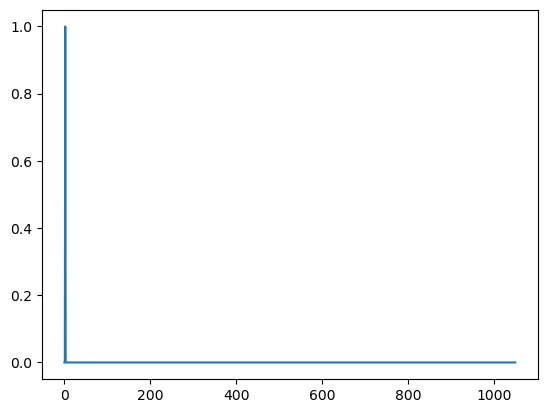

In [167]:
plt.plot(val_predicted_probs[4].cpu())

In [168]:

val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)

In [169]:
print(val_predicted_labels[4])
print(image_val_labels[4])

tensor(2)
tensor(2)


In [170]:
    #val_predicted_probs -= val_predicted_probs.min(dim=1).values.unsqueeze(1)
    
    #val_predicted_probs = val_predicted_probs/(val_predicted_probs.sum(dim=1).unsqueeze(1))
    #val_predicted_probs = val_predicted_probs.cpu().numpy()

In [171]:
print(val_predicted_probs[10].min())
print(val_predicted_probs[10].sum())

tensor(9.7920e-16)
tensor(1.0000)


In [172]:
image_val_labels = image_val_labels.type(torch.LongTensor)

In [173]:
val_predicted_labels

tensor([   1,    1,    2,  ..., 1049, 1049, 1049])

# Secondo top2 method

In [174]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 1000 for x in range(900, 1000, 1)]
for t in possible_thresholds:#ATTENZIONE QUA E' DIVERSO
    entropy_threshold = t
    thresholds.append(entropy_threshold)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if (top2.values[0]-top2.values[1]) > 1.01*entropy_threshold*top2.values[0]:#species 
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
                if label_best_specie == image_val_labels[i]:#guessed species is correct
                    #n_correct_described_samples+=1
                    n_correct_species+=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
        else:#genus
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
                #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
                #ATTENZIONE QUA E' DIVERSO
                if val_predicted_labels_genus[i].item() == species2genus[image_val_labels[i]].item():#guessed genus is correct
                    #n_correct_described_samples+=1
                    n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_3949/3974386884.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


In [175]:
for index in range(0,len(correct_genus_rate),1):
    print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0
0.5159903251814029
0.9696969696969697



1
0.5165278151034668
0.9696969696969697



2
0.5181402848696587
0.9696969696969697



3
0.5184090298306907
0.9696969696969697



4
0.5189465197527546
0.9696969696969697



5
0.5192152647137867
0.9696969696969697



6
0.5200214995968826
0.9696969696969697



7
0.5219027143241064
0.9696969696969697



8
0.5232464391292663
0.9696969696969697



9
0.5237839290513303
0.9696969696969697



10
0.5243214189733942
0.9696969696969697



11
0.5256651437785541
0.9693877551020408



12
0.5267401236226821
0.9693877551020408



13
0.5270088685837141
0.9693877551020408



14
0.528083848427842
0.9693877551020408



15
0.5302338081160978
0.9693877551020408



16
0.5315775329212578
0.9693877551020408



17
0.5323837678043537
0.9693877551020408



18
0.5350712174146735
0.969078540507112



19
0.5366836871808653
0.969078540507112



20
0.5388336468691212
0.969078540507112



21
0.541521096479441
0.969078540507112



22
0.542596076323569
0.969078540507112



23
0.5

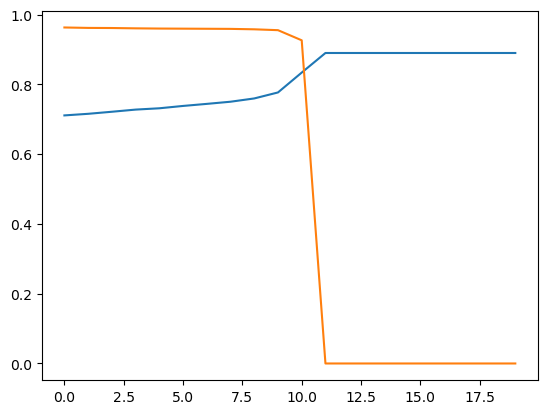

In [176]:
plt.plot(correct_genus_rate[-20:])
plt.plot(correct_species_rate[-20:])

In [177]:
n_undescribed_samples

3721

In [52]:
raise Exception

Exception: 

In [53]:
thresholds

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009,
 0.01,
 0.011,
 0.012,
 0.013,
 0.014,
 0.015,
 0.016,
 0.017,
 0.018,
 0.019,
 0.02,
 0.021,
 0.022,
 0.023,
 0.024,
 0.025,
 0.026,
 0.027,
 0.028,
 0.029,
 0.03,
 0.031,
 0.032,
 0.033,
 0.034,
 0.035,
 0.036,
 0.037,
 0.038,
 0.039,
 0.04,
 0.041,
 0.042,
 0.043,
 0.044,
 0.045,
 0.046,
 0.047,
 0.048,
 0.049,
 0.05,
 0.051,
 0.052,
 0.053,
 0.054,
 0.055,
 0.056,
 0.057,
 0.058,
 0.059,
 0.06,
 0.061,
 0.062,
 0.063,
 0.064,
 0.065,
 0.066,
 0.067,
 0.068,
 0.069,
 0.07,
 0.071,
 0.072,
 0.073,
 0.074,
 0.075,
 0.076,
 0.077,
 0.078,
 0.079,
 0.08,
 0.081,
 0.082,
 0.083,
 0.084,
 0.085,
 0.086,
 0.087,
 0.088,
 0.089,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095,
 0.096,
 0.097,
 0.098,
 0.099,
 0.1,
 0.101,
 0.102,
 0.103,
 0.104,
 0.105,
 0.106,
 0.107,
 0.108,
 0.109,
 0.11,
 0.111,
 0.112,
 0.113,
 0.114,
 0.115,
 0.116,
 0.117,
 0.118,
 0.119,
 0.12,
 0.121,
 0.122,
 0.123,
 0.124,
 0.125,
 0.126,

# Random Forest

In [20]:
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, image_train_labels)

train_predicted_labels = clf.predict(complete_train_features_scaled)
print('train')
val_predicted_labels= clf.predict(complete_val_features_scaled)
print('val')
temp_val_predicted_probs = clf.predict_proba(complete_val_features_scaled)
print('proba')
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),n_classes))
for i, cls in enumerate(np.arange(n_classes)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

train
val
proba


In [21]:
temp_val_predicted_probs

array([[0.        , 0.89183333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.90766667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7425    , ..., 0.        , 0.01      ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.8675    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.9625    ]])

In [22]:
feature_importances = clf.feature_importances_
feature_importances

array([0.00012523, 0.00010174, 0.00011856, ..., 0.        , 0.        ,
       0.        ])

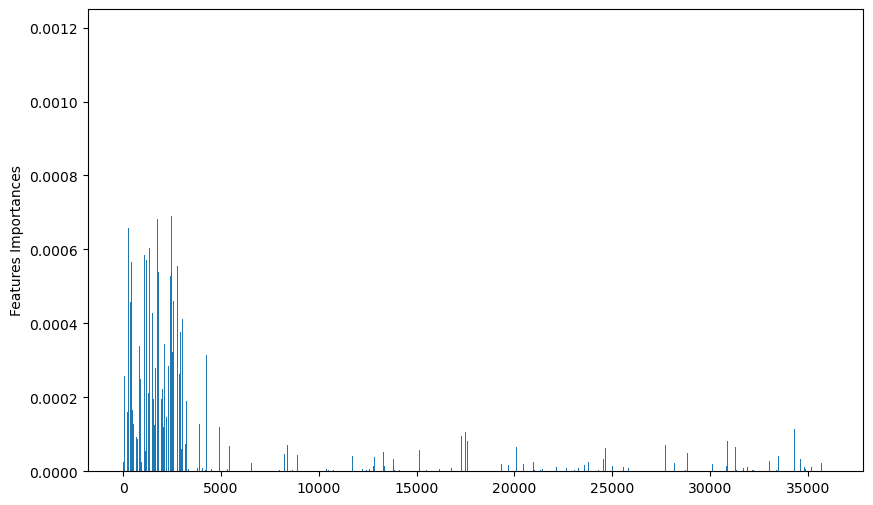

In [23]:
feature_names = [f'Feature {i+1}' for i in range(complete_train_features.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.ylabel('Features Importances')
plt.show()

# Accuracies

In [24]:
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")

print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")

Training species accuracy:0.9999233070020707
Validation species accuracy:0.45751258087706687


In [25]:
import math
n_correct_genus = 0
for i in range(len(image_val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    #print(val_predicted_labels[i])
    #print(val_predicted_probs[i].argmax())
    #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[image_val_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(image_val_labels)}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
val_predicted_labels_genus[i]

tensor(366)

0
0.0
0.9904666332162569



1
0.004448210124973522
0.9904666332162569



2
0.009425969074348655
0.9904666332162569



3
0.013238720610040246
0.9904666332162569



4
0.01779284049989409
0.9904666332162569



5
0.02160559203558568
0.9904666332162569



6
0.025630163101037915
0.9904666332162569



7
0.030502012285532724
0.9904666332162569



8
0.03526795170514722
0.9904666332162569



9
0.039504342300360096
0.9902157551430005



10
0.04363482313069265
0.9902157551430005



11
0.047553484431264566
0.9902157551430005



12
0.05242533361575937
0.9902157551430005



13
0.05708536327049354
0.9902157551430005



14
0.06163948316034738
0.9902157551430005



15
0.06619360305020122
0.9902157551430005



16
0.0699004448210125
0.9902157551430005



17
0.07487820377038763
0.9902157551430005



18
0.08027960177928405
0.9902157551430005



19
0.08652827790722305
0.9902157551430005



20
0.09087057826731625
0.9902157551430005



21
0.09563651768693074
0.9902157551430005



22
0.10040245710654522
0.99021

# Top-2 Method

In [31]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        
        sorted_probs = np.sort(val_predicted_probs[i])
        sorted_probs = sorted_probs[::-1]
        
        prob_diff = abs(sorted_probs[0] - sorted_probs[1])
        #print(prob_diff)
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if prob_diff >= entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if prob_diff < entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

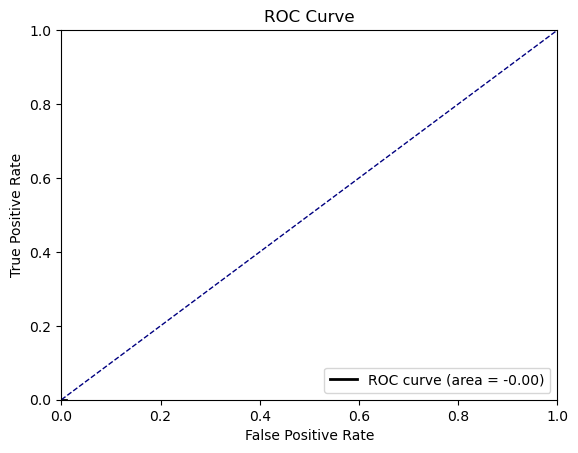

In [42]:
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fprs, tprs)

plt.figure()
plt.plot(fprs, tprs, color='black', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

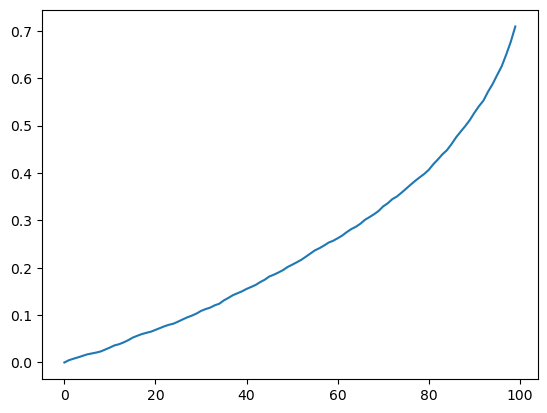

In [52]:
plt.plot(correct_genus_rate)

0.04986902625680434


Text(0, 0.5, 'Correct Genus Rate')

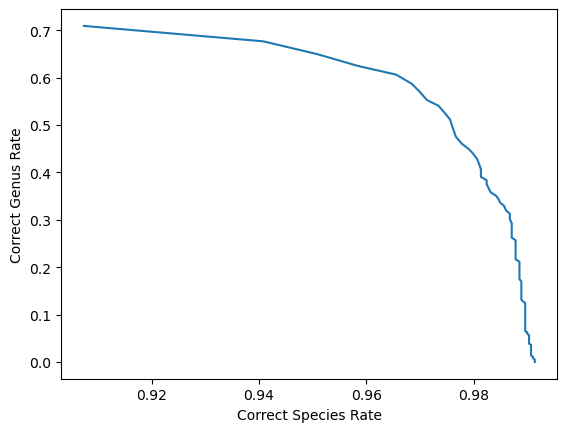

In [53]:
area_correct = auc(correct_species_rate,correct_genus_rate)
print(area_correct)

plt.plot(correct_species_rate,correct_genus_rate)
plt.xlabel("Correct Species Rate")
plt.ylabel("Correct Genus Rate")

In [54]:
for index in range(0,100,1):
    print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0
0.0
0.9913854989231874



1
0.004815795810257645
0.9913854989231874



2
0.007946063086925114
0.9910265613783201



3
0.010835540573079701
0.9910265613783201



4
0.01396580784974717
0.990667623833453



5
0.01709607512641464
0.990667623833453



6
0.019022393450517698
0.990667623833453



7
0.020948711774620755
0.990667623833453



8
0.02335660967974958
0.990667623833453



9
0.027450036118468576
0.990667623833453



10
0.031543462557187575
0.990667623833453



11
0.036118468576932336
0.990667623833453



12
0.03852636648206116
0.9903086862885858



13
0.042379003130267275
0.9903086862885858



14
0.04695400915001204
0.9903086862885858



15
0.05249217433180833
0.9903086862885858



16
0.05634481098001445
0.9903086862885858



17
0.059956657837707684
0.9899497487437185



18
0.06260534553334939
0.9899497487437185



19
0.06501324343847821
0.9895908111988514



20
0.06886588008668433
0.9895908111988514



21
0.07271851673489044
0.9895908111988514



22
0.07657115338309656
0.989590811

In [56]:
print(correct_genus_rate[50])
correct_species_rate[50]

0.20635685046954008


0.9885139985642498